_Laura Martínez González de Aledo_

## Práctica 2

______

In [187]:
import pandas as pd
import numpy as np
import re

In [188]:
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from collections import defaultdict

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn import model_selection, naive_bayes, svm
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [189]:
#Graficos
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [190]:
#SVM
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [191]:
#Random seed
np.random.seed(1234)

#Snowball Stemmer
ss = SnowballStemmer('spanish')

### Ejercicio 1

**Lea el contenido del fichero csv en un DataFrame. Se sugiere utilizar la función pandas .read_csv. Atención a la codificación de los datos entrantes.**

In [192]:
hotel = pd.read_csv(r"hotel.csv")  # no pongo: encoding='utf-8' porque en Mac no es necesario
hotel

,text,label
0,Es un gran hotel; el mejor de Asunción. Buenas...,3
1,hola. no suelo criticar jamas lo que paso pero...,3
2,Escogi meses antes de mi boda una habitacion p...,3
3,Voy a se Lo mas equitativo posible; porque soy...,3
4,Esta es una experiencia de septiembre de 2016;...,3
...,...,...
195,Excelente atención; instalaciones; comodidad; ...,5
196,Realmente disfrutamos en pareja por 2 noches d...,5
197,Muy buena excelente; muy buena ubicación; cerc...,5
198,Pasé con mi familia la celebración del Año Nue...,5


### Ejercicio 2

**Realice el pre-procesamiento que considere necesario. Puede utilizar funciones de la librería NLTK o spaCy, a su voluntad. Recomendamos una escritura modular del código, para poder hacer pruebas posteriormente, viendo si se obtienen mejores resultados al utilizar stop-words, al realizar una extracción de formas canónicas, etc.**

In [193]:
# Elimimamos lineas vacías.
hotel['text'].dropna(inplace=True)

In [194]:
hotel['text']=[re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A) for doc in hotel['text']]

In [195]:
# Conversión a minúsculas
hotel['text'] = [entry.lower().strip() for entry in hotel['text']]

In [196]:
# Tokenization
hotel['text']= [word_tokenize(entry) for entry in hotel['text']]

In [197]:
# Eliminamos Stop words, Stemming y Lematización.
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

In [198]:
for index,entry in enumerate(hotel['text']):
    # Inicialización de Final_words vacía
    Final_words_s = []
    Final_words_w = []
    # Inicializacion de WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag
    for word, tag in pos_tag(entry):
        # Eliminamos Stop words y caracteres no alfabéticos
        if word not in stopwords.words('spanish') and word.isalpha():
            word_Final_w = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            word_Final_s = ss.stem(word)
            Final_words_s.append(word_Final_s)
            Final_words_w.append(word_Final_w)
    # El texto preprocesado se almacena en 'text_final'
    hotel.loc[index,'final_wordnet'] = str(Final_words_w)
    hotel.loc[index,'final_snowball'] = str(Final_words_s)
print(hotel['final_wordnet'].head())

0    ['gran', 'hotel', 'mejor', 'asuncin', 'buenas'...
1    ['hola', 'suelo', 'criticar', 'jamas', 'paso',...
2    ['escogi', 'me', 'boda', 'habitacion', 'hacer'...
3    ['voy', 'ma', 'equitativo', 'posible', 'person...
4    ['experiencia', 'septiembre', 'asi', 'quizas',...
Name: final_wordnet, dtype: object


In [199]:
print(hotel['final_snowball'].head())

0    ['gran', 'hotel', 'mejor', 'asuncin', 'buen', ...
1    ['hol', 'suel', 'critic', 'jam', 'pas', 'vez',...
2    ['escogi', 'mes', 'bod', 'habitacion', 'hac', ...
3    ['voy', 'mas', 'equit', 'posibl', 'person', 'b...
4    ['experient', 'septiembr', 'asi', 'quiz', 'cos...
Name: final_snowball, dtype: object


### Ejercicio 3

**Divida el conjunto de documentos en un subconjunto de entrenamiento y otro de evaluación.**

In [200]:
hotel['label'].value_counts(normalize=True)

3    0.555
5    0.445
Name: label, dtype: float64

In [201]:
# División en conjunto de entrenamiento y test
Train_X_SB, Test_X_SB,Train_X_WN, Test_X_WN, Train_Y, Test_Y = model_selection.train_test_split(hotel['final_snowball'],
                                                                                                hotel['final_wordnet'],
                                                                                                hotel['label'],test_size=0.3, stratify=hotel['label'])

In [202]:
Train_Y.value_counts(normalize=True)

3    0.557143
5    0.442857
Name: label, dtype: float64

In [203]:
Test_Y.value_counts(normalize=True)

3    0.55
5    0.45
Name: label, dtype: float64

### Ejercicio 4

**Convierta el corpus de documentos en una matriz TF-idf.Lo más cómodo es utilizar el vectorizador TfidfVectorizer, que forma parte de sklearn. ¿Tiene influencia en el resultado final el número máximo de features a utilizar?**

In [204]:
# Codificación de etiquetas (categorías)
# Las categorías tienen una etiqueta tipo string, pero los algoritmos de clasifiación necesitan un valor numérico
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

In [205]:
Train_Y

array([0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 0])

In [206]:
Test_Y

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0])

Se crea 4 vectores Tfidf para entrenamiento y evaluación de las muestras reducidas por el WordNetLemmatizer y Snowball Stemmer.

In [207]:
hotel['final_snowball']

0      ['gran', 'hotel', 'mejor', 'asuncin', 'buen', ...
1      ['hol', 'suel', 'critic', 'jam', 'pas', 'vez',...
2      ['escogi', 'mes', 'bod', 'habitacion', 'hac', ...
3      ['voy', 'mas', 'equit', 'posibl', 'person', 'b...
4      ['experient', 'septiembr', 'asi', 'quiz', 'cos...
                             ...                        
195    ['excelent', 'atencin', 'instal', 'comod', 'li...
196    ['realment', 'disfrut', 'parej', 'noch', 'hote...
197    ['buen', 'excelent', 'buen', 'ubicacin', 'cerc...
198    ['pas', 'famili', 'celebracin', 'ao', 'nuev', ...
199    ['amabil', 'personal', 'excepcin', 'hac', 'hot...
Name: final_snowball, Length: 200, dtype: object

In [208]:
# Vectorización: consitución de matrices tf-idf a partir de los subconjuntos de entrenamiento y test

Tfidf_vectSB = TfidfVectorizer(min_df=0., max_df=1., norm='l2',
                     use_idf=True, smooth_idf=True)
Tfidf_vectWN = TfidfVectorizer(min_df=0., max_df=1., norm='l2',
                     use_idf=True, smooth_idf=True)
Tfidf_vectSB.fit(hotel['final_snowball'])
Tfidf_vectWN.fit(hotel['final_wordnet'])
Train_X_TfidfSB = Tfidf_vectSB.transform(Train_X_SB)
Test_X_TfidfSB = Tfidf_vectSB.transform(Test_X_SB)
Train_X_TfidfWN = Tfidf_vectWN.transform(Train_X_WN)
Test_X_TfidfWN = Tfidf_vectWN.transform(Test_X_WN)

In [209]:
train_x_arrWN = Train_X_TfidfWN.toarray()
vocab = Tfidf_vectWN.get_feature_names()
pd.DataFrame(np.round(train_x_arrWN, 2), columns=vocab).head()

,abierta,abitacin,abre,absolutamente,abundante,abundantes,ac,acceder,acceso,accesorios,...,web,wi,wifi,wilma,yeespazamiento,yendo,zas,zelaya,zona,zonas
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.24,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [210]:
train_x_arrSB = Train_X_TfidfSB.toarray()
vocab = Tfidf_vectSB.get_feature_names()
pd.DataFrame(np.round(train_x_arrSB, 2), columns=vocab).head()

,abiert,abitacin,abre,absolut,abund,ac,acced,acces,accesori,accion,...,vuelv,web,wi,wifi,wilm,yeespaz,yend,zas,zelay,zon
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.24,0.0,0.0,0.0,0.0,0.0,0.0


### Ejercicio 5

**Llegados a este punto, realice modelos de entrenamiento al menos con algoritmos de clasificador bayesiano ingenuo y máquinas SVM. Obtenga resultados de precisión de la clasificación, así como las matrices de confusión para ambos modelos.**

### NAIVE BAYES

### Dataset SnowBall Stemmer

In [211]:
#Modelo
model_Naive = naive_bayes.MultinomialNB()
model_Naive.fit(Train_X_TfidfSB,Train_Y)

MultinomialNB()

In [212]:
# Predicciones
predictions_NB = model_Naive.predict(Test_X_TfidfSB)

In [213]:
# Precisión del modelo 
accuracy_score(predictions_NB, Test_Y)*100

61.66666666666667

__Matriz de Confusion__

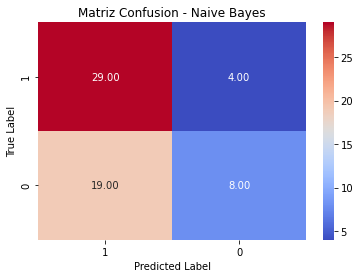

In [214]:
sns.heatmap(confusion_matrix(Test_Y,predictions_NB),annot=True, fmt=".2f", cmap="coolwarm",
            xticklabels = ["1", "0"] , yticklabels = ["1", "0"])
plt.title("Matriz Confusion - Naive Bayes")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

__Curva ROC__

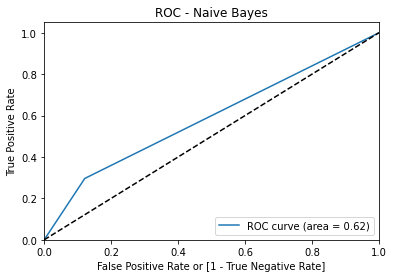

In [215]:
auc_score_nb = accuracy_score(predictions_NB, Test_Y)
fpr, tpr, thresholds = metrics.roc_curve(Test_Y,predictions_NB, 
                                         drop_intermediate= False)
plt.plot(fpr, tpr , label = 'ROC curve (area = %0.2f)' % auc_score_nb)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('ROC - Naive Bayes')
plt.legend(loc="lower right")
plt.show()

### Dataset Word Net Lemmatizer

In [216]:
model_Naive = naive_bayes.MultinomialNB()
model_Naive.fit(Train_X_TfidfWN,Train_Y)

MultinomialNB()

In [217]:
# Predicciones
predictions_NB = model_Naive.predict(Test_X_TfidfWN)

In [218]:
# Precisión del modelo 
accuracy_score(predictions_NB, Test_Y)*100

68.33333333333333

__Matriz de Confusión__

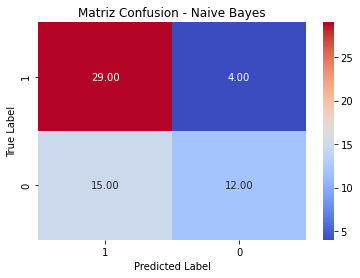

In [219]:
sns.heatmap(confusion_matrix(Test_Y,predictions_NB),annot=True, fmt=".2f", cmap="coolwarm",
            xticklabels = ["1", "0"] , yticklabels = ["1", "0"])
#sns.palplot(sns.cubehelix_palette(8))
plt.title("Matriz Confusion - Naive Bayes")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

__Curva ROC__

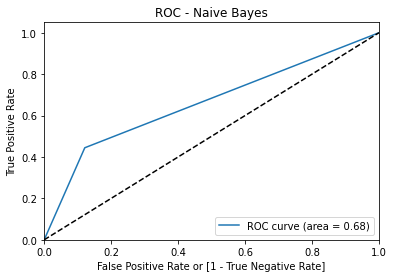

In [220]:
auc_score_nb = accuracy_score(predictions_NB, Test_Y)
fpr, tpr, thresholds = metrics.roc_curve(Test_Y,predictions_NB, 
                                         drop_intermediate= False)
plt.plot(fpr, tpr , label = 'ROC curve (area = %0.2f)' % auc_score_nb)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('ROC - Naive Bayes')
plt.legend(loc="lower right")
plt.show()

###  SVM

El modelo Support Vector Machines representa los elementos como puntos en un espacio y comienza la busqueda de un hiperplano que los separe y clasifique adecuadamente. Las desventajas que tiene son de que se basa en dos ejes o dos variables predictoras y que la realidad de algunos datos es que no se separan por una función lineal.

### Dataset SnowBall Stemmer

In [221]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_TfidfSB,Train_Y)

SVC(gamma='auto', kernel='linear')

In [222]:
predictions_SVM = SVM.predict(Test_X_TfidfSB)

El primer modelo SVM con el dataset de SnowBall obtiene un 68.3%, mejor que el modelo de Naive Bayes del SnowBall; sin embargo, es menor al modelo Naive Bayes del dataset WordNet Lemmatizer.

In [223]:
# Precisión del modelo 
accuracy_score(predictions_SVM, Test_Y)*100

70.0

**Matriz de Confusión**

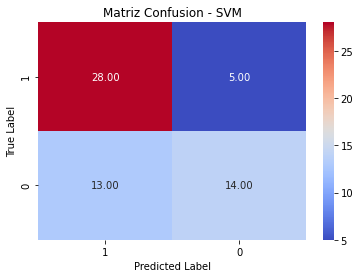

In [224]:
sns.heatmap(confusion_matrix(Test_Y,predictions_SVM),annot=True, fmt=".2f", cmap="coolwarm",#cmap="coolwarm",
            xticklabels = ["1", "0"] , yticklabels = ["1", "0"])
#sns.palplot(sns.cubehelix_palette(8))
plt.title("Matriz Confusion - SVM")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

La curva ROC muestra un mejor desempeño que el modelo Naive Bayes de Snowball Stemmer.

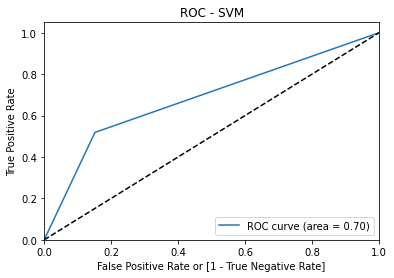

In [225]:
auc_score_svm = accuracy_score(predictions_SVM, Test_Y)
fpr, tpr, thresholds = metrics.roc_curve(Test_Y,predictions_SVM, 
                                         drop_intermediate= False)
plt.plot(fpr, tpr , label = 'ROC curve (area = %0.2f)' % auc_score_svm)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('ROC - SVM')
plt.legend(loc="lower right")
plt.show()

Otra manera de mejorar el modelo entrenado es en base a la estimación de hiperparametros. Utilizamos la función de Search Grid basado en el metodo de Cross Validation. Se crea un diccionario con los diferentes parametros que entrenara el modelo SVM y mediante el validación cruzada de los dataset evaluará cada modelo, hasta obtener el mejor modelo.

In [226]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001,'auto'], 
              'kernel': ['rbf','poly','sigmoid','linear']}

In [227]:
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

In [228]:
grid.fit(Train_X_TfidfSB, Train_Y)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.571, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.571, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.571, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.536, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.536, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.571, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] .........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ....... C=0.1, gamma=0.1, kernel=poly, score=0.571, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] ....... C=0.1, gamma=0.1, kernel=poly, score=0.536, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] ....... C=0.1, gamma=0.1, kernel=poly, score=0.536, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=sigmoid ................................
[CV] .... C=0.1, gamma=0.1, kernel=sigmoid, score=0.571, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=sigmoid ................................
[CV] .... C=0.1, gamma=0.1, kernel=sigmoid, score=0.571, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=sigmoid ................................
[CV] .... C=0.1, gamma=0.1, kernel=sigmoid, score=0.571, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=sigmoid ................................
[CV] .... C=0.1, gamma=0.1, kernel=sigmoid, score=0.536, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=sigmoid ................................
[CV] .

[CV] . C=0.1, gamma=0.0001, kernel=sigmoid, score=0.571, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=sigmoid .............................
[CV] . C=0.1, gamma=0.0001, kernel=sigmoid, score=0.571, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=sigmoid .............................
[CV] . C=0.1, gamma=0.0001, kernel=sigmoid, score=0.536, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=sigmoid .............................
[CV] . C=0.1, gamma=0.0001, kernel=sigmoid, score=0.536, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=linear ..............................
[CV] .. C=0.1, gamma=0.0001, kernel=linear, score=0.571, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=linear ..............................
[CV] .. C=0.1, gamma=0.0001, kernel=linear, score=0.571, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=linear ..............................
[CV] .. C=0.1, gamma=0.0001, kernel=linear, score=0.571, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=linear ..............................
[CV] .

[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.571, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.571, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.536, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.536, total=   0.0s
[CV] C=1, gamma=0.01, kernel=poly ....................................
[CV] ........ C=1, gamma=0.01, kernel=poly, score=0.571, total=   0.0s
[CV] C=1, gamma=0.01, kernel=poly ....................................
[CV] ........ C=1, gamma=0.01, kernel=poly, score=0.571, total=   0.0s
[CV] C=1, gamma=0.01, kernel=poly ....................................
[CV] ........ C=1, gamma=0.01, kernel=poly, score=0.571, total=   0.0s
[CV] C=1, gamma=0.01, kernel=poly ....................................
[CV] .

[CV] ........ C=1, gamma=auto, kernel=poly, score=0.536, total=   0.0s
[CV] C=1, gamma=auto, kernel=poly ....................................
[CV] ........ C=1, gamma=auto, kernel=poly, score=0.536, total=   0.0s
[CV] C=1, gamma=auto, kernel=sigmoid .................................
[CV] ..... C=1, gamma=auto, kernel=sigmoid, score=0.571, total=   0.0s
[CV] C=1, gamma=auto, kernel=sigmoid .................................
[CV] ..... C=1, gamma=auto, kernel=sigmoid, score=0.571, total=   0.0s
[CV] C=1, gamma=auto, kernel=sigmoid .................................
[CV] ..... C=1, gamma=auto, kernel=sigmoid, score=0.571, total=   0.0s
[CV] C=1, gamma=auto, kernel=sigmoid .................................
[CV] ..... C=1, gamma=auto, kernel=sigmoid, score=0.536, total=   0.0s
[CV] C=1, gamma=auto, kernel=sigmoid .................................
[CV] ..... C=1, gamma=auto, kernel=sigmoid, score=0.536, total=   0.0s
[CV] C=1, gamma=auto, kernel=linear ..................................
[CV] .

[CV] ..... C=10, gamma=0.01, kernel=linear, score=0.714, total=   0.0s
[CV] C=10, gamma=0.01, kernel=linear .................................
[CV] ..... C=10, gamma=0.01, kernel=linear, score=0.750, total=   0.0s
[CV] C=10, gamma=0.01, kernel=linear .................................
[CV] ..... C=10, gamma=0.01, kernel=linear, score=0.679, total=   0.0s
[CV] C=10, gamma=0.01, kernel=linear .................................
[CV] ..... C=10, gamma=0.01, kernel=linear, score=0.821, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.571, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.571, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.571, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .

[CV] .......... C=100, gamma=1, kernel=rbf, score=0.679, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.750, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.714, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.714, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.786, total=   0.0s
[CV] C=100, gamma=1, kernel=poly .....................................
[CV] ......... C=100, gamma=1, kernel=poly, score=0.571, total=   0.0s
[CV] C=100, gamma=1, kernel=poly .....................................
[CV] ......... C=100, gamma=1, kernel=poly, score=0.571, total=   0.0s
[CV] C=100, gamma=1, kernel=poly .....................................
[CV] .

[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.571, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.571, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.536, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.536, total=   0.0s
[CV] C=100, gamma=0.001, kernel=poly .................................
[CV] ..... C=100, gamma=0.001, kernel=poly, score=0.571, total=   0.0s
[CV] C=100, gamma=0.001, kernel=poly .................................
[CV] ..... C=100, gamma=0.001, kernel=poly, score=0.571, total=   0.0s
[CV] C=100, gamma=0.001, kernel=poly .................................
[CV] ..... C=100, gamma=0.001, kernel=poly, score=0.571, total=   0.0s
[CV] C=100, gamma=0.001, kernel=poly .................................
[CV] .

[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.679, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.821, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=poly ..................................
[CV] ...... C=1000, gamma=0.1, kernel=poly, score=0.571, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=poly ..................................
[CV] ...... C=1000, gamma=0.1, kernel=poly, score=0.571, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=poly ..................................
[CV] ...... C=1000, gamma=0.1, kernel=poly, score=0.571, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=poly ..................................
[CV] ...... C=1000, gamma=0.1, kernel=poly, score=0.536, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=poly ..................................
[CV] ...... C=1000, gamma=0.1, kernel=poly, score=0.536, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=sigmoid ...............................
[CV] .

[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.571, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.536, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.536, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=poly ...............................
[CV] ... C=1000, gamma=0.0001, kernel=poly, score=0.571, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=poly ...............................
[CV] ... C=1000, gamma=0.0001, kernel=poly, score=0.571, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=poly ...............................
[CV] ... C=1000, gamma=0.0001, kernel=poly, score=0.571, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=poly ...............................
[CV] ... C=1000, gamma=0.0001, kernel=poly, score=0.536, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=poly ...............................
[CV] .

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    4.0s finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'auto'],
                         'kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
             verbose=3)

In [229]:
grid_predictions = grid.predict(Test_X_TfidfSB)

El mejor modelo obtiene 70% de accuracy y con 18 casos incorrectos para el dataset de evaluación mediante el método Snowball.

In [230]:
# Precisión del modelo 
print("SVM Accuracy Score -> ",accuracy_score(grid_predictions, Test_Y)*100)
print("SVM Matrix:")
print(confusion_matrix(Test_Y,grid_predictions))

SVM Accuracy Score ->  68.33333333333333
SVM Matrix:
[[30  3]
 [16 11]]


**Dataset Word Net Lemmatizer**

In [231]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_TfidfWN,Train_Y)

SVC(gamma='auto', kernel='linear')

In [232]:
predictions_SVM = SVM.predict(Test_X_TfidfWN)

In [233]:
# Precisión del modelo 
accuracy_score(predictions_SVM, Test_Y)*100

71.66666666666667

**Matriz de Confusión**

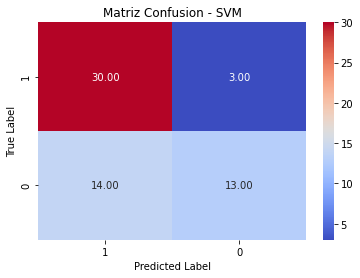

In [234]:
sns.heatmap(confusion_matrix(Test_Y,predictions_SVM),annot=True, fmt=".2f", cmap="coolwarm",
            xticklabels = ["1", "0"] , yticklabels = ["1", "0"])
#sns.palplot(sns.cubehelix_palette(8))
plt.title("Matriz Confusion - SVM")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

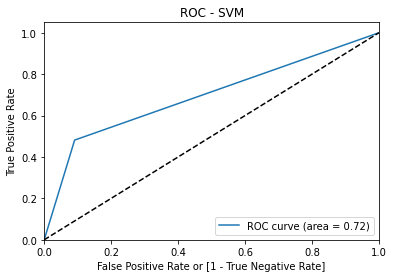

In [235]:
auc_score_svm = accuracy_score(predictions_SVM, Test_Y)
fpr, tpr, thresholds = metrics.roc_curve(Test_Y,predictions_SVM, 
                                         drop_intermediate= False)
plt.plot(fpr, tpr , label = 'ROC curve (area = %0.2f)' % auc_score_svm)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('ROC - SVM')
plt.legend(loc="lower right")
plt.show()

In [236]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001,'auto'], 
              'kernel': ['rbf','poly','sigmoid','linear']}

In [237]:
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

In [238]:
grid.fit(Train_X_TfidfWN, Train_Y)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.571, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.571, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.571, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.536, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.536, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.571, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] .........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ....... C=0.1, gamma=0.1, kernel=poly, score=0.571, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] ....... C=0.1, gamma=0.1, kernel=poly, score=0.571, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] ....... C=0.1, gamma=0.1, kernel=poly, score=0.536, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] ....... C=0.1, gamma=0.1, kernel=poly, score=0.536, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=sigmoid ................................
[CV] .... C=0.1, gamma=0.1, kernel=sigmoid, score=0.571, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=sigmoid ................................
[CV] .... C=0.1, gamma=0.1, kernel=sigmoid, score=0.571, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=sigmoid ................................
[CV] .... C=0.1, gamma=0.1, kernel=sigmoid, score=0.571, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=sigmoid ................................
[CV] .

[CV] . C=0.1, gamma=0.0001, kernel=sigmoid, score=0.571, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=sigmoid .............................
[CV] . C=0.1, gamma=0.0001, kernel=sigmoid, score=0.571, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=sigmoid .............................
[CV] . C=0.1, gamma=0.0001, kernel=sigmoid, score=0.536, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=sigmoid .............................
[CV] . C=0.1, gamma=0.0001, kernel=sigmoid, score=0.536, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=linear ..............................
[CV] .. C=0.1, gamma=0.0001, kernel=linear, score=0.571, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=linear ..............................
[CV] .. C=0.1, gamma=0.0001, kernel=linear, score=0.571, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=linear ..............................
[CV] .. C=0.1, gamma=0.0001, kernel=linear, score=0.571, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=linear ..............................
[CV] .

[CV] ....... C=1, gamma=0.1, kernel=linear, score=0.679, total=   0.0s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] ....... C=1, gamma=0.1, kernel=linear, score=0.714, total=   0.0s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] ....... C=1, gamma=0.1, kernel=linear, score=0.750, total=   0.0s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] ....... C=1, gamma=0.1, kernel=linear, score=0.571, total=   0.0s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] ....... C=1, gamma=0.1, kernel=linear, score=0.750, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.571, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.571, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] .

[CV] .... C=1, gamma=0.0001, kernel=linear, score=0.750, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=linear ................................
[CV] .... C=1, gamma=0.0001, kernel=linear, score=0.571, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=linear ................................
[CV] .... C=1, gamma=0.0001, kernel=linear, score=0.750, total=   0.0s
[CV] C=1, gamma=auto, kernel=rbf .....................................
[CV] ......... C=1, gamma=auto, kernel=rbf, score=0.571, total=   0.0s
[CV] C=1, gamma=auto, kernel=rbf .....................................
[CV] ......... C=1, gamma=auto, kernel=rbf, score=0.571, total=   0.0s
[CV] C=1, gamma=auto, kernel=rbf .....................................
[CV] ......... C=1, gamma=auto, kernel=rbf, score=0.571, total=   0.0s
[CV] C=1, gamma=auto, kernel=rbf .....................................
[CV] ......... C=1, gamma=auto, kernel=rbf, score=0.536, total=   0.0s
[CV] C=1, gamma=auto, kernel=rbf .....................................
[CV] .

[CV] ...... C=10, gamma=0.1, kernel=linear, score=0.786, total=   0.0s
[CV] C=10, gamma=0.1, kernel=linear ..................................
[CV] ...... C=10, gamma=0.1, kernel=linear, score=0.536, total=   0.0s
[CV] C=10, gamma=0.1, kernel=linear ..................................
[CV] ...... C=10, gamma=0.1, kernel=linear, score=0.786, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.571, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.571, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.571, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.536, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] .

[CV] .......... C=100, gamma=1, kernel=rbf, score=0.679, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.714, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.679, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.536, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.679, total=   0.0s
[CV] C=100, gamma=1, kernel=poly .....................................
[CV] ......... C=100, gamma=1, kernel=poly, score=0.571, total=   0.0s
[CV] C=100, gamma=1, kernel=poly .....................................
[CV] ......... C=100, gamma=1, kernel=poly, score=0.571, total=   0.0s
[CV] C=100, gamma=1, kernel=poly .....................................
[CV] .

[CV] ... C=100, gamma=0.001, kernel=linear, score=0.786, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf .................................
[CV] ..... C=100, gamma=0.0001, kernel=rbf, score=0.571, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf .................................
[CV] ..... C=100, gamma=0.0001, kernel=rbf, score=0.571, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf .................................
[CV] ..... C=100, gamma=0.0001, kernel=rbf, score=0.571, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf .................................
[CV] ..... C=100, gamma=0.0001, kernel=rbf, score=0.536, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf .................................
[CV] ..... C=100, gamma=0.0001, kernel=rbf, score=0.536, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV] .... C=100, gamma=0.0001, kernel=poly, score=0.571, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV] .

[CV] ..... C=1000, gamma=0.01, kernel=poly, score=0.536, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=poly .................................
[CV] ..... C=1000, gamma=0.01, kernel=poly, score=0.536, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=sigmoid ..............................
[CV] .. C=1000, gamma=0.01, kernel=sigmoid, score=0.714, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=sigmoid ..............................
[CV] .. C=1000, gamma=0.01, kernel=sigmoid, score=0.750, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=sigmoid ..............................
[CV] .. C=1000, gamma=0.01, kernel=sigmoid, score=0.786, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=sigmoid ..............................
[CV] .. C=1000, gamma=0.01, kernel=sigmoid, score=0.536, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=sigmoid ..............................
[CV] .. C=1000, gamma=0.01, kernel=sigmoid, score=0.786, total=   0.0s
[CV] C=1000, gamma=0.01, kernel=linear ...............................
[CV] .

[CV] ..... C=1000, gamma=auto, kernel=poly, score=0.571, total=   0.0s
[CV] C=1000, gamma=auto, kernel=poly .................................
[CV] ..... C=1000, gamma=auto, kernel=poly, score=0.536, total=   0.0s
[CV] C=1000, gamma=auto, kernel=poly .................................
[CV] ..... C=1000, gamma=auto, kernel=poly, score=0.536, total=   0.0s
[CV] C=1000, gamma=auto, kernel=sigmoid ..............................
[CV] .. C=1000, gamma=auto, kernel=sigmoid, score=0.571, total=   0.0s
[CV] C=1000, gamma=auto, kernel=sigmoid ..............................
[CV] .. C=1000, gamma=auto, kernel=sigmoid, score=0.571, total=   0.0s
[CV] C=1000, gamma=auto, kernel=sigmoid ..............................
[CV] .. C=1000, gamma=auto, kernel=sigmoid, score=0.571, total=   0.0s
[CV] C=1000, gamma=auto, kernel=sigmoid ..............................
[CV] .. C=1000, gamma=auto, kernel=sigmoid, score=0.536, total=   0.0s
[CV] C=1000, gamma=auto, kernel=sigmoid ..............................
[CV] .

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    4.2s finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'auto'],
                         'kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
             verbose=3)

In [239]:
grid_predictions = grid.predict(Test_X_TfidfWN)

In [240]:
# Precisión del modelo 
accuracy_score(grid_predictions, Test_Y)*100

63.33333333333333

__Matriz de Confusión__

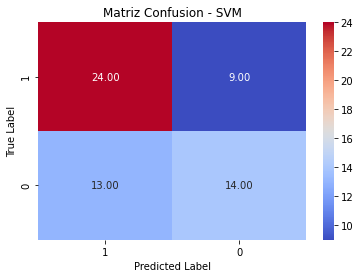

In [241]:
sns.heatmap(confusion_matrix(Test_Y,grid_predictions),annot=True, fmt=".2f", cmap="coolwarm",
            xticklabels = ["1", "0"] , yticklabels = ["1", "0"])
#sns.palplot(sns.cubehelix_palette(8))
plt.title("Matriz Confusion - SVM")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

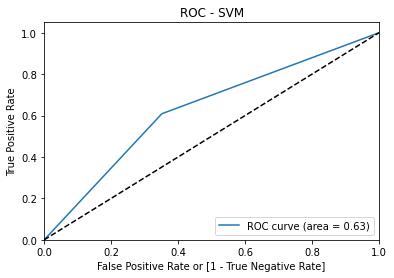

In [242]:
auc_score_svm = accuracy_score(grid_predictions, Test_Y)
fpr, tpr, thresholds = metrics.roc_curve(grid_predictions, Test_Y, 
                                         drop_intermediate= False)
plt.plot(fpr, tpr , label = 'ROC curve (area = %0.2f)' % auc_score_svm)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('ROC - SVM')
plt.legend(loc="lower right")
plt.show()

### Ejercicio 6

**Comente los resultados obtenidos.¿Qué factores influyen? ¿Los resultados obtenidos son los esperados inicialmente? ¿A qué se deben estos resultados? Piense en la calidad del conjunto de datos con los que está trabajando**

Vemos que el modelo con mejor accuracy es el de SVM con los datos transformados mediante WordNet Lemmatizer con un **71,66%**. Consideramos el método Snowball Stemmer por que muestra mejor reducción de formas canónicas de los documentos en español que WordNet Lemmatizer. Sin embargo, después de realizar la práctica, compruebó que su reducción permite a los modelos trabajar de forma más precisa que el otro metodo. También creo que se podría revisar con otros tipos de modelo como árboles de decisión.